In [4]:
import pandas
import matplotlib
import seaborn
import collections
import itertools

import sys
sys.path.append('..')

from helpers import (ECOSYSTEMS, DATE_RANGE, load_data, create_snapshot, load_graph, 
                     evolution_linlog_regressions, RE_SEMVER, compare_distributions, 
                     savefig, x_index, gini)

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('Set1', n_colors=len(ECOSYSTEMS))
seaborn.set_style('whitegrid')

In [5]:
FIG_SIZE = (8, 4)
FIG_SIZE_WIDE = (10, 4)
FIG_DATE_RANGE = (DATE_RANGE[0], DATE_RANGE[-1])  #(pandas.to_datetime('2007-01-01'), DATE_RANGE[-1])
COLORS = {ecosystem: seaborn.color_palette()[i] for i, ecosystem in enumerate(ECOSYSTEMS)}

In [6]:
df_data = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=', ')
    packages, dependencies = load_data(ecosystem)
    df_data[ecosystem] = {
        'packages': packages, 
        'dependencies': dependencies,
    }

cargo, cpan, cran, npm, nuget, packagist, rubygems, 

## Characteristics

In [7]:
df = pandas.DataFrame(index=ECOSYSTEMS)

for ecosystem, data in df_data.items():
    # Number of packages, versions and dependencies
    df.loc[ecosystem, 'packages'] = len(data['packages'].groupby('package'))
    df.loc[ecosystem, 'releases'] = len(data['packages'])
    df.loc[ecosystem, 'dependencies'] = len(data['dependencies'])
    
    # Oldest package
    df.loc[ecosystem, 'from_date'] = data['packages']['time'].min()
    df.loc[ecosystem, 'to_date'] = data['packages']['time'].max()
    
    # Latest snapshot
    sn_packages, sn_dependencies = create_snapshot(data['packages'], data['dependencies'], df.loc[ecosystem, 'to_date'])
    df.loc[ecosystem, 'sn_dependencies'] = len(sn_dependencies)
    
df.T

,cargo,cpan,cran,npm,nuget,packagist,rubygems
packages,8726,34105,11727,462077,84308,97149,132117
releases,48482,258987,67280,3.03752e+06,935651,668905,795222
dependencies,150251,1.07812e+06,163600,1.36112e+07,1.66539e+06,1.8633e+06,1.89357e+06
from_date,2014-11-11 00:22:07,1995-08-19 22:00:00,1997-10-08 19:56:17,2010-11-09 23:36:08,2011-01-07 07:49:38,1994-08-23 00:00:00,1999-12-31 13:30:00
to_date,2017-04-05 11:51:32,2017-04-05 11:19:02,2017-04-12 00:54:15,2017-04-05 00:38:39,2017-04-05 10:17:32,2017-04-05 08:43:17,2017-04-04 17:26:30
sn_dependencies,21840,105429,30524,1.1885e+06,129678,176230,190447


In [8]:
df.sum()

packages             830209.0
releases            5812044.0
dependencies       20425419.0
sn_dependencies     1842648.0
dtype: float64

## Packages, releases and dependencies over time

In [9]:
# Time of first and next release
for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .sort_values(['package', 'time'])
        .set_index(['package', 'version'])
        .assign(next_release=lambda d: d['time'].shift(-1))
    )
    index_of_last_releases = (
        df
        .groupby(level='package', sort=False)
        .tail(1)
        .index
    )
    df.loc[index_of_last_releases, 'next_release'] = pandas.NaT
    df = df.reset_index()
    
    df_data[ecosystem]['packages'] = (
        df
        .groupby('package')
         [['time']]
         .min()
         .assign(first_release=lambda d: d['time'])
         [['first_release']]
         .reset_index()
         .merge(df, how='left', on='package')
    )

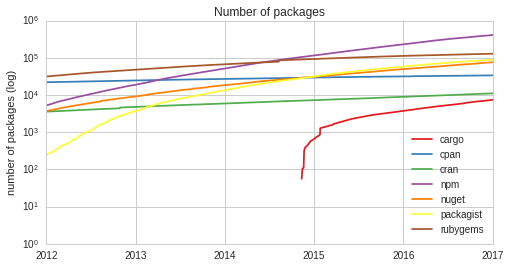

In [10]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = pandas.DataFrame()

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby('package')
        [['time']]
        .min()
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    data_temp = data_temp.join(evolution_linlog_regressions(df), how='outer')
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='number of packages (log)',
    title='Number of packages',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_number_of_packages')

In [11]:
data_temp

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.989234,0.965464,0.837063,0.826492,0.918253,0.767815,0.876609
lin-log,0.817681,0.870401,0.967940,0.917559,0.912982,0.889836,0.934470
log-lin,0.744346,0.632989,0.531041,0.491057,0.545215,0.148010,0.646627
log-log,0.987443,0.950058,0.930930,0.974796,0.949624,0.254829,0.886421


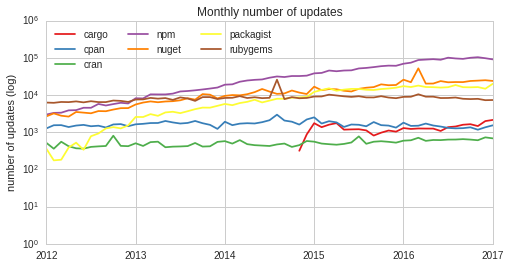

In [12]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = pandas.DataFrame()

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .query('first_release != time')  # drop initial release
        [['time']]
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    data_temp = data_temp.join(evolution_linlog_regressions(df), how='outer')
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='number of updates (log)',
    title='Monthly number of updates',
    xlim=FIG_DATE_RANGE,
)

ax.legend(ncol=len(ECOSYSTEMS) // 2, loc='upper left')

savefig(figure, 'act_number_of_updates_by_month')

In [13]:
# Incorrect, truncate at 17-04-01
data_temp

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.134560,0.868247,0.888917,0.794148,0.735940,0.684385,0.749187
lin-log,0.040946,0.729938,0.834399,0.895872,0.781777,0.513556,0.558865
log-lin,0.182017,0.571625,0.508181,0.364364,0.416005,0.272672,0.414352
log-log,0.188940,0.926060,0.833102,0.822264,0.862026,0.250097,0.702425


In [14]:
# What happened for rubygems in mid 2014?

df = (
    df_data['rubygems']['packages']
    .query('first_release != time')  # drop initial release
    .query('time >= "2014-08-01" and time < "2014-09-01"')
)

## Delay between successive releases

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


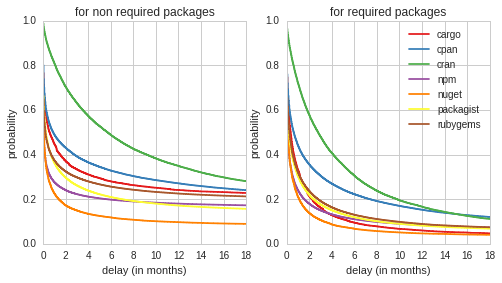

In [15]:
import lifelines
from lifelines.statistics import logrank_test

figure, (ax_left, ax_right) = matplotlib.pyplot.subplots(ncols=2)
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()
tests = collections.OrderedDict()

for ecosystem, data in df_data.items():
    kmp_df = (
        data['packages']
        .assign(observed=lambda d: ~d['next_release'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_release'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
        .assign(required=lambda d: d['package'].isin(data['dependencies']['dependency']))
    )
    
    required = kmp_df['required'] == True
    
    kmp.fit(kmp_df[~required]['duration'], kmp_df[~required]['observed'], label=ecosystem)
    kmp.plot(ax=ax_left, color=COLORS[ecosystem], legend=None, ci_show=False)
    
    kmp.fit(kmp_df[required]['duration'], kmp_df[required]['observed'], label=ecosystem)
    kmp.plot(ax=ax_right, color=COLORS[ecosystem], ci_show=False)
    
    tests[ecosystem] = logrank_test(
        kmp_df[~required]['duration'], kmp_df[required]['duration'],
        kmp_df[~required]['observed'], kmp_df[required]['observed'],
        alpha=0.99
    )

#figure.suptitle('Survival analysis: release update')    
ax_left.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='for non required packages',
    xlim=(0, 18),
    ylim=(0, 1)
)    

ax_right.set(
    xlabel='delay (in months)',
    ylabel='probability',
    title='for required packages',
    xlim=(0, 18),
    ylim=(0, 1),
)


savefig(figure, 'act_survival_update_release')

In [16]:
for ecosystem, test in tests.items():
    print('{}: {}, significant: {} ({:})'.format(ecosystem, test.test_result, test.is_significant, test.p_value))

cargo: Reject Null, significant: True (0.0)
cpan: Reject Null, significant: True (0.0)
cran: Reject Null, significant: True (0.0)
npm: Reject Null, significant: True (0.0)
nuget: Reject Null, significant: True (3.705051991993873e-141)
packagist: Reject Null, significant: True (0.0)
rubygems: Reject Null, significant: True (0.0)


## Updates by package

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


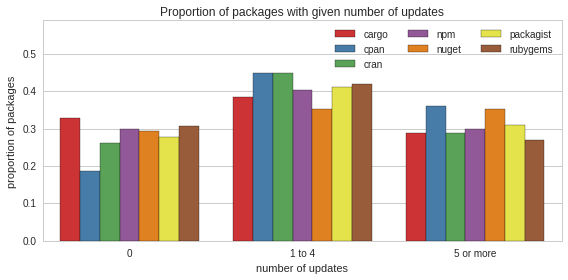

In [17]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = []

bins = [0, 1, 5, pandas.np.inf]
labels = ['0', '1 to 4', '5 or more']

for ecosystem, data in df_data.items():    
    df = (
        data['packages']
        .assign(updates=1)
        .groupby('package')
        [['updates']]
        .count()
        .assign(updates=lambda d: d['updates'] - 1)  # Initial update
        ['updates']
    )
    
    counter = collections.Counter(
            pandas.cut(
                df,
                bins=bins,
                labels=labels,
                right=False,
                include_lowest=True,
            )
        )
    
    nb_packages = len(data['packages'].drop_duplicates(['package']))
    for label in labels: 
        data_temp.append((ecosystem, label, counter[label] / nb_packages))
    

seaborn.barplot(
    data=pandas.DataFrame.from_records(data_temp, columns=['ecosystem', 'value', 'p']),
    x='value', 
    y='p', 
    hue='ecosystem',
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Proportion of packages with given number of updates',
    xlabel='number of updates',
    ylabel='proportion of packages',
    ylim=(0, 0.59),
)

ax.legend(ncol=len(ECOSYSTEMS) // 2)

matplotlib.pyplot.tight_layout()

savefig(figure, 'act_nb_packages_updates_by_package')

In [18]:
(
    pandas.DataFrame.from_records(
        data_temp, 
        columns=['ecosystem', 'value', 'p']
    )
    .sort_values(['value', 'ecosystem'])
    .pivot('ecosystem', 'value', 'p')
)

value,0,1 to 4,5 or more
ecosystem,,,
cargo,0.328444,0.383910,0.287646
cpan,0.187509,0.450403,0.362088
cran,0.261277,0.450499,0.288224
npm,0.298680,0.403266,0.298054
nuget,0.292973,0.354106,0.352920
packagist,0.277059,0.412449,0.310492
rubygems,0.308575,0.420801,0.270624


## Updates by package age for the last year

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


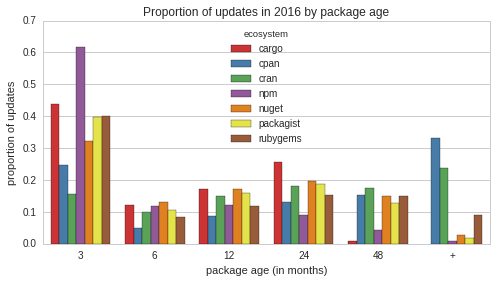

In [19]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

bins = [0, 3, 6, 12, 24, 48, pandas.np.inf]
#labels = ['[0,3[', '[3,6[', '[6,12[', '[12,24[', '[24, 36[', '36+']
labels = ['3', '6', '12', '24', '48', '+']

df = pandas.concat(
    [
        (
            data['packages']
            [data['packages']['time'].dt.year == 2016]  # Keep updates for 2016
            .query('first_release != time')  # Remove initial releases
            .assign(age=lambda d: (d['time'] - d['first_release']).dt.days / 30)
            .groupby('age', as_index=False)
            .agg({'version': 'count'})
            .assign(p=lambda d: d['version'] / d['version'].sum())
            .assign(age=lambda d: 
                pandas.cut(
                    d['age'],
                    bins=bins,
                    labels=labels,
                    right=False,
                    include_lowest=True,
                )
            )
            .groupby('age', as_index=False)
            .sum()
            .assign(ecosystem=ecosystem)
        )
        for ecosystem, data in df_data.items()
    ]
)

seaborn.barplot(
    data=df,
    x='age', 
    y='p', 
    hue='ecosystem',
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Proportion of updates in 2016 by package age',
    xlabel='package age (in months)',
    ylabel='proportion of updates',
)

savefig(figure, 'act_packages_updates_by_age_2016')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


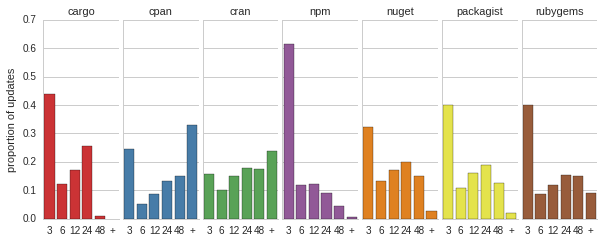

In [20]:
grid = (
    seaborn.FacetGrid(
        data=df, 
        col='ecosystem',
        hue='ecosystem',
    )
    .map(seaborn.barplot, 'age', 'p')
    .set_titles("{col_name}")
    .set_axis_labels('', 'proportion of updates')
)

grid.fig.set_size_inches(FIG_SIZE)
grid.fig.suptitle('Propotion of updates in 2016 by package age (in months)')

savefig(grid.fig, 'act_packages_updates_by_age_2016_b')

In [21]:
df.pivot('ecosystem', 'age', 'p').T

ecosystem,cargo,cpan,cran,npm,nuget,packagist,rubygems
age,,,,,,,
3,0.438302,0.246777,0.157141,0.615728,0.322516,0.399165,0.400375
6,0.123039,0.050744,0.099461,0.119357,0.131695,0.107399,0.085419
12,0.172254,0.088189,0.151228,0.122020,0.171262,0.160109,0.117631
24,0.256479,0.131584,0.179871,0.090257,0.198093,0.187365,0.154259
48,0.009926,0.151648,0.173959,0.044822,0.148649,0.126673,0.151230
+,NaN,0.331059,0.238339,0.007816,0.027785,0.019289,0.091086


## Changeability index

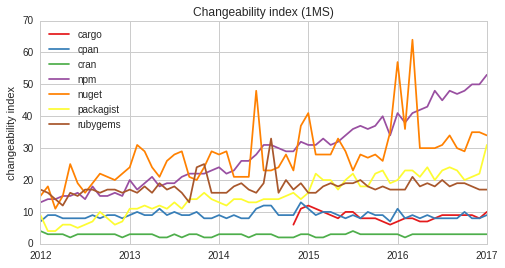

In [22]:
figure, ax = matplotlib.pyplot.subplots(1)
figure.set_size_inches(FIG_SIZE)

date_freq = '1MS'
dates = pandas.date_range(DATE_RANGE[0], DATE_RANGE[-1] + pandas.DateOffset(months=1), freq=date_freq)
data_temp = pandas.DataFrame(index=dates, columns=ECOSYSTEMS)

for ecosystem, data in df_data.items():
    for i in range(len(dates) - 1): 
        start, end = dates[i], dates[i+1]
        df_temp = data['packages'].query('first_release != time')
        df_temp = df_temp[(df_temp['time'] >= start) & (df_temp['time'] < end)]

        if len(df_temp) == 0:
            continue

        index = x_index(
            df_temp
            .groupby('package')
            .count()
            ['time']
            .values
        )
        data_temp.loc[start, ecosystem] = index

data_temp.plot(ax=ax)

ax.set(
    title='Changeability index ({})'.format(date_freq),
    xlabel='',
    ylabel='changeability index',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_volatility_index')

In [23]:
pandas.concat([data_temp.min(), data_temp.max(), data_temp.iloc[-1]])

cargo          6
cpan           7
cran           2
npm           13
nuget         11
packagist      4
rubygems      12
cargo         12
cpan          13
cran           4
npm           53
nuget         64
packagist     31
rubygems      33
cargo        NaN
cpan         NaN
cran         NaN
npm          NaN
nuget        NaN
packagist    NaN
rubygems     NaN
dtype: object

In [24]:
(
    df_data['nuget']['packages']
    .query('first_release != time')
    .query('"2016-03-01" <= time and time < "2016-04-01"')
    .groupby('package')
    .agg({'version': 'count'})
    .sort_values('version', ascending=False)
)

,version
package,
Codentia.Common.Membership.dll,132
Codentia.Common.WebControls.dll,108
Codentia.Common.Logging.dll,94
Codentia.Common.Config.dll,94
Paket.PowerShell,89
Paket,89
Paket.Core,89
angularjs.TypeScript.DefinitelyTyped,70
angular-load.TypeScript.DefinitelyTyped,66


## Gini index

In [25]:
# Proportion of packages having an update in 2016

for ecosystem, data in df_data.items():
    all_packages = (
        data['packages']
        .query('first_release <= "2016-12-31"')
        .drop_duplicates('package')
    )
    
    updated_packages = (
        data['packages']
        .pipe(lambda d: d[d['time'].dt.year == 2016])
        .query('first_release != time')
        .drop_duplicates('package')
    )
    
    print('{}: {}/{} = {}%'.format(
        ecosystem, 
        len(updated_packages),
        len(all_packages),
        len(updated_packages) / len(all_packages) * 100
    ))

cargo: 3932/7407 = 53.08491967058189%
cpan: 5347/33667 = 15.882020970089405%
cran: 3798/11061 = 34.33685923515053%
npm: 167707/408762 = 41.02803098135345%
nuget: 30365/75848 = 40.03401539921949%
packagist: 37754/88632 = 42.596353461503746%
rubygems: 22610/128403 = 17.60862285149101%


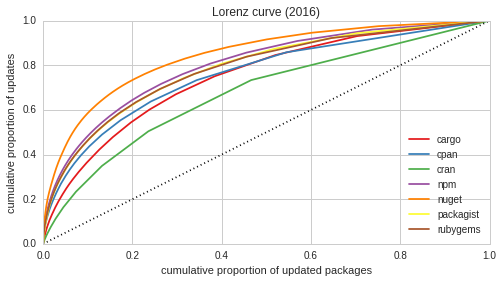

In [26]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = []

for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .pipe(lambda d: d[d['time'].dt.year == 2016])
        .query('first_release != time')
        .groupby('package', as_index=False)
        .agg({'version': 'count'})
        .sort_values('version', ascending=False)
        .assign(n=1)
        .assign(n=lambda d: d['n'].cumsum() / len(d))
        .assign(version=lambda d: d['version'] / d['version'].sum())
        .assign(version=lambda d: d['version'].cumsum())
        .set_index('n')
        [['version']]
        .rename(columns={'version': ecosystem})
    )
    
    data_temp.append(df)
    df.plot(ax=ax)

ax.plot([0, 1], [0, 1], 'k:')
    
ax.set(
    title='Lorenz curve (2016)',
    xlim=(0, 1),
    ylim=(0, 1),
    xlabel='cumulative proportion of updated packages',
    ylabel='cumulative proportion of updates',
)

savefig(figure, 'act_lorenz_curve_2016')

In [27]:
for df in data_temp:
    ecosystem = df.columns[0]
    perc = (
        df
        .query('{} >= 0.8'.format(ecosystem))
        .reset_index()
        ['n']
        .iloc[0]
    )
    print('{}: {}'.format(ecosystem, perc))

cargo: 0.4547304170905392
cpan: 0.45109407144193003
cran: 0.5992627698788836
npm: 0.3640814038769998
nuget: 0.2742631318952742
packagist: 0.3902897706203316
rubygems: 0.39703670942061037
